# Lettura dati span

In [14]:
import csv
import qutip
import numpy as np
import scipy.optimize as opt
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt



def plain(xy, a, b, d):
    x, y = xy
    return a*x + b*y +d #z = a*x + b*y +d

bloch= qutip.Bloch()
field = ["Ch", "Voltage", "Theta", "Eta", "DOP", "Power", "S1", "S2", "S3"]

data = np.empty((4, 4), dtype=object)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        data[i, j] = []

with open("csv/output_2025-04-14_11-24.csv", mode="r", newline="") as file:
    rdr = csv.DictReader(file)
    rdr.fieldnames = field
    for i in range(1,5):
        file.seek(0)
        for row in rdr:
            if(row["Ch"]==str(i)):
                data[i-1,0].append(float(row["S1"]))
                data[i-1,1].append(float(row["S2"]))
                data[i-1,2].append(float(row["S3"]))
                data[i-1,3].append(float(row["Voltage"]))
        

### Fit con piano

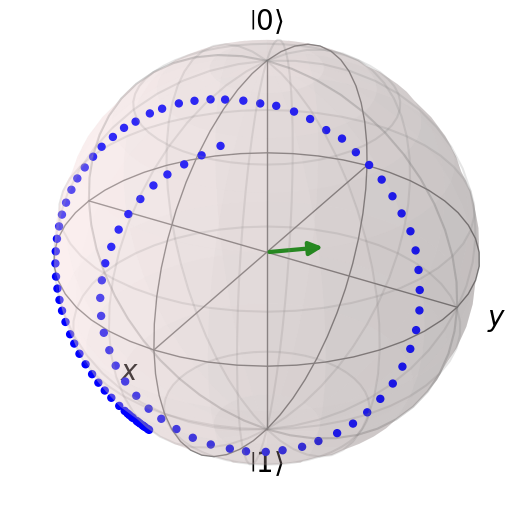

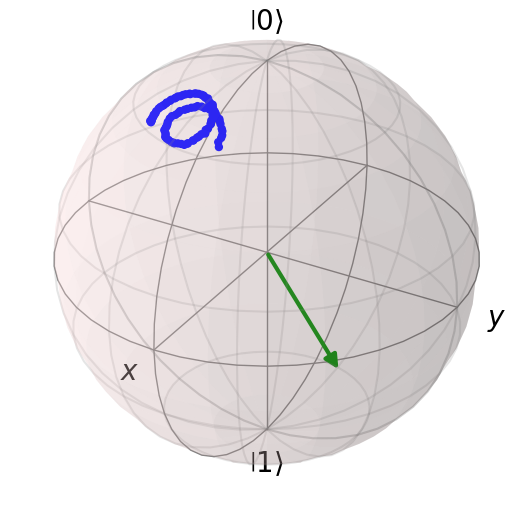

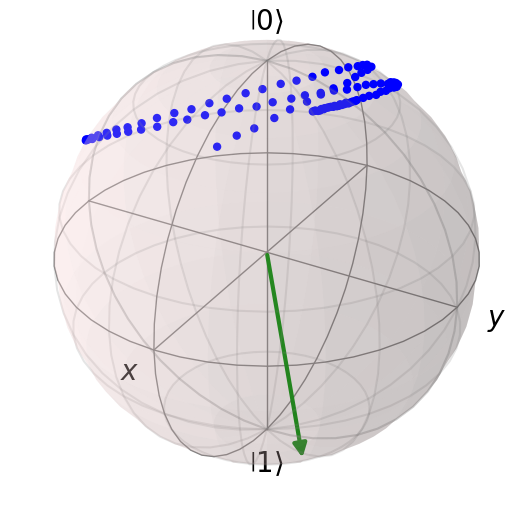

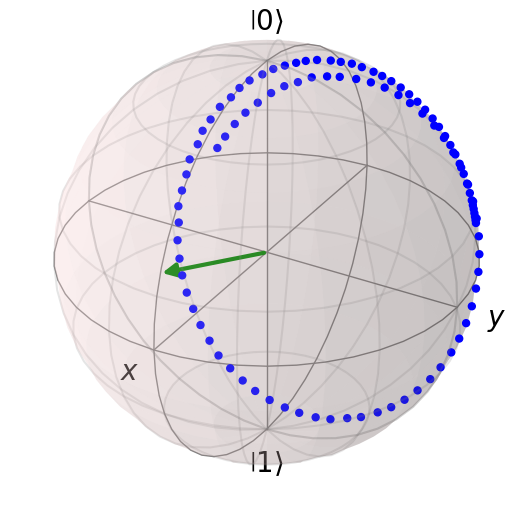

In [15]:

vect = np.empty((4,3))

for i in range(4):
    bloch.clear()
    bloch.add_points([data[i,0], data[i,1], data[i,2]])
    # Fit the data to a plane
    parameters, covariance = opt.curve_fit(plain, (data[i,0],data[i,1]), data[i,2])
    a, b, _= parameters
    vect_t = [a, b, -1]
    vect[i] = vect_t/np.linalg.norm(vect_t)
    bloch.add_vectors(vect[i])
    bloch.show()
    #bloch.save('img/test1_plain_bloch'+str(i)+'.pdf')


### Rotazione del piano

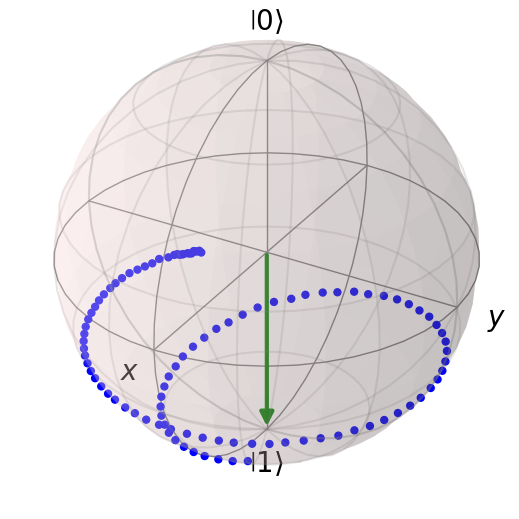

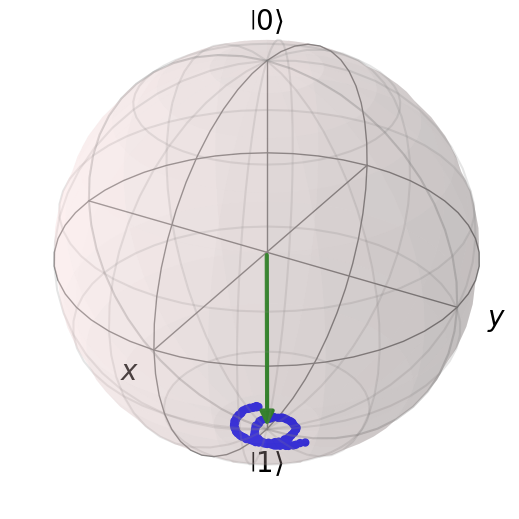

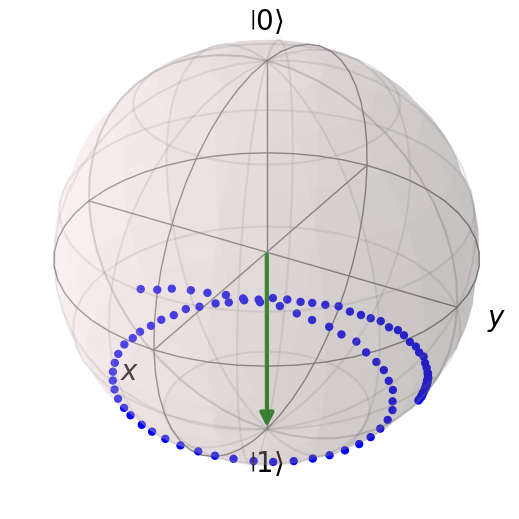

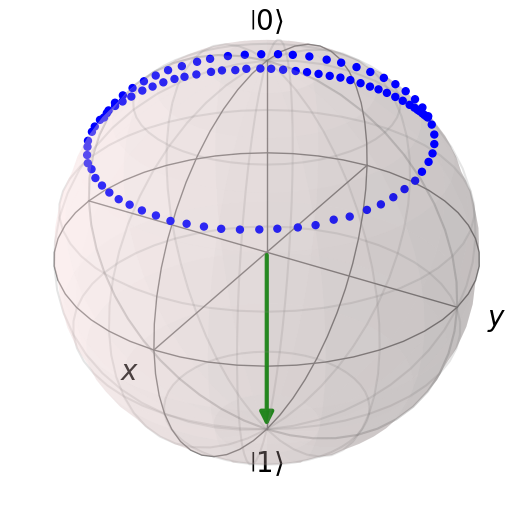

In [16]:
for i in range(4):
    d = 1
    while d>0.01:
        # Rotate the data to align with the z-axis
        rot_vect = np.cross([0,0,1], vect[i])
        rot_vect = rot_vect/np.linalg.norm(rot_vect)
        angle = -np.arccos(np.dot([0,0,1], vect[i]))
        rot = R.from_rotvec(angle*rot_vect)
        bloch.clear()
        for j in range(len(data[i,0])):
            new_point = rot.apply([data[i,0][j], data[i,1][j], data[i,2][j]])
            #print(new_point)
            data[i,0][j]=new_point[0]
            data[i,1][j]=new_point[1]
            data[i,2][j]=new_point[2]
        # Display new vector
        parameters, covariance = opt.curve_fit(plain, (data[i,0],data[i,1]), data[i,2])
        a, b, _= parameters
        vect_t = [a, b, -1]
        vect[i] = vect_t/np.linalg.norm(vect_t)
        d = np.max([np.abs(vect[i][0]), np.abs(vect[i][1])])
    # Display new data on the Bloch sphere
    bloch.add_points([data[i,0], data[i,1], data[i,2]])
    bloch.add_vectors(vect[i])
    bloch.show()
    

### Plot 2D dei punti del piano

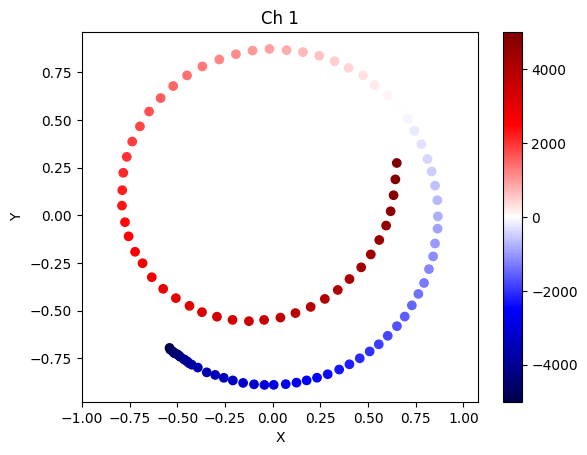

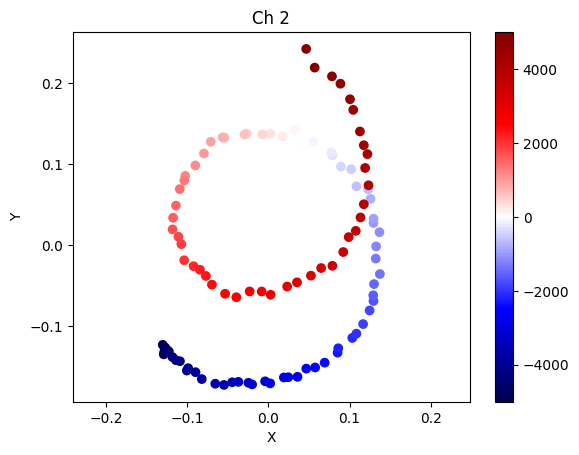

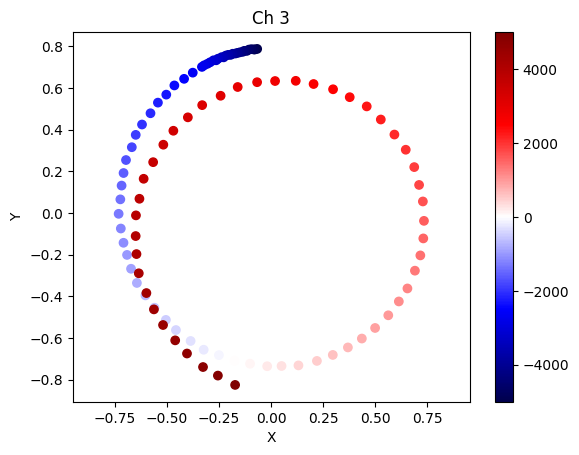

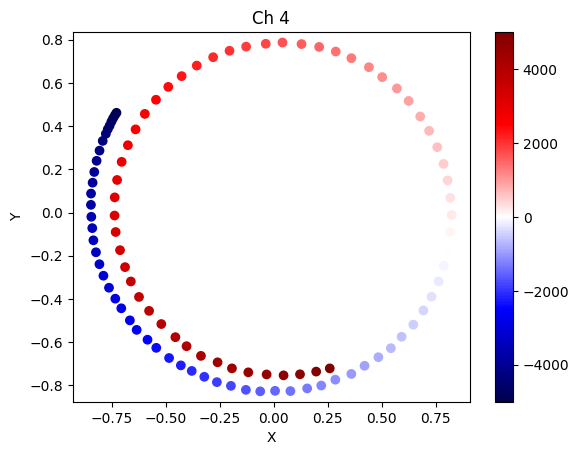

In [17]:

for i in range(4):
    chart = plt.figure()
    ax = chart.add_subplot(111)
    # Display data on 2D plot
    trace = ax.scatter(data[i,0], data[i,1], c=data[i,3], cmap='seismic', marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Ch '+str(i+1))
    ax.set_aspect('equal', adjustable='datalim')
    plt.colorbar(trace)
    plt.show()
    #chart.savefig('img/test1_plain_2D'+str(i)+'.pdf')

### Cambio di coordinate e fit con retta

Ch 1 lim: -1800.0: m = 0.06275517054590796±0.0007518933184168308, q = 44.23248240537145±1.920887541280924
Ch 2 lim: -3800.0: m = 0.06647997887693424±0.001050456738428118, q = 88.50289851699539±2.771295234854626
Ch 3 lim: -2200.0: m = 0.06882488163763266±0.0006432805874019293, q = -97.84709268861776±1.6273854631954439
Ch 4 lim: -2800.0: m = 0.057414977606758844±0.00033777213412612385, q = -4.460101150576175±0.8551706744447203


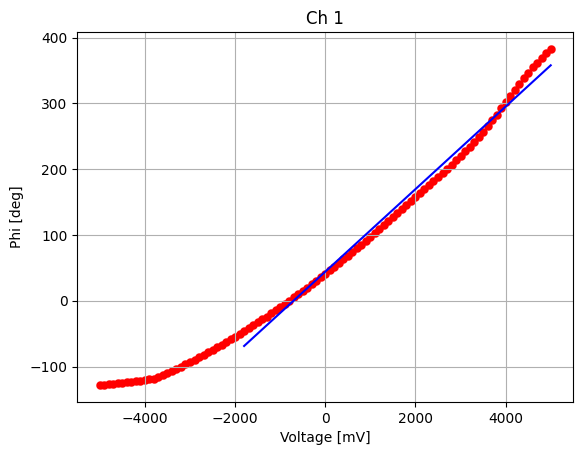

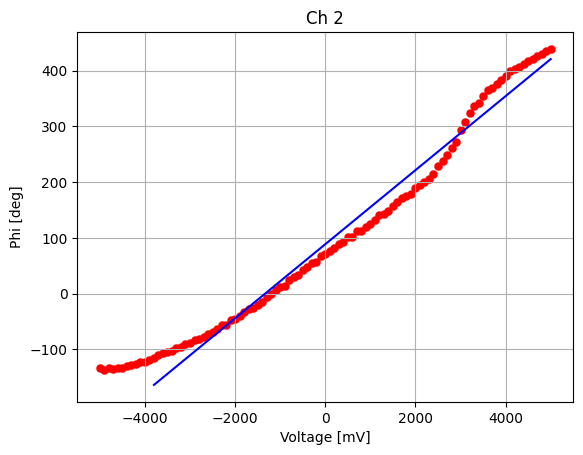

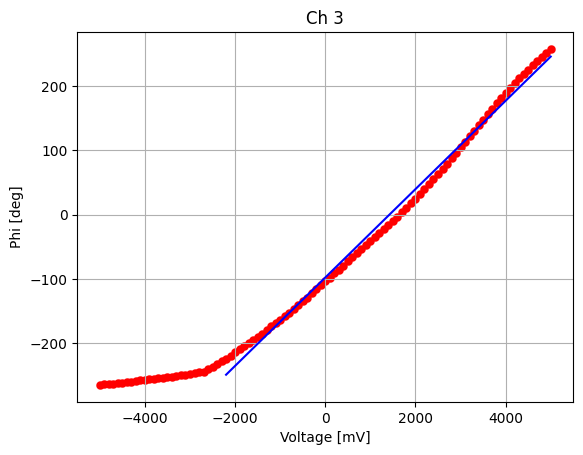

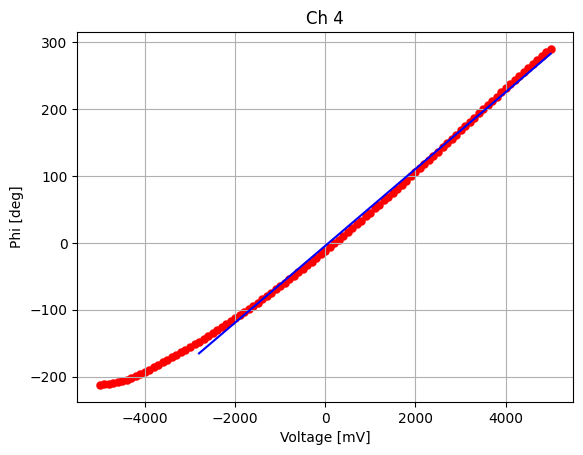

" chart1.savefig('img/test1_polar_fit0.pdf')\nchart2.savefig('img/test1_polar_fit1.pdf')\nchart3.savefig('img/test1_polar_fit2.pdf')\nchart4.savefig('img/test1_polar_fit3.pdf') "

In [18]:
polar = np.empty((4,2), dtype=object)
epsilon = 50

for i in range(polar.shape[0]):
    for j in range(polar.shape[1]):
        polar[i, j] = []
chart1 = plt.figure()
c1 = chart1.add_subplot(111)
chart2 = plt.figure()
c2 = chart2.add_subplot(111)
chart3 = plt.figure()
c3 = chart3.add_subplot(111)
chart4 = plt.figure()
c4 = chart4.add_subplot(111)
ax =[c1, c2, c3, c4]
def line(x, m, q):
    return m*x +q #y = m*x + q
lim = [0, 0, 0, 0]
const = [[0,0], [0,0], [0,0], [0,0]]
err = [[0,0], [0,0], [0,0], [0,0]]
for i in range(4):
    for j in range(len(data[i,0])):
        rho = np.sqrt(data[i,0][j]**2 + data[i,1][j]**2)
        phi = np.arctan2(data[i,1][j], data[i,0][j])
        phi = np.degrees(phi)
        """ if data[i,1][j]<0:
            phi += 360 """
        if j>0 and (phi - polar[i,1][j-1])<-(360-epsilon):
            if data[i,3][j]>0:
                phi += 360
            else:
                k=j-1
                while k>=0:
                    polar[i,1][k-1] -= 360
                    k -= 1
        elif j>0 and (phi - polar[i,1][j-1])>(360-epsilon):
            if data[i,3][j]>0:
                phi -= 360
            else:
                k=j-1
                while k>=0:
                    polar[i,1][k-1] += 360
                    k -= 1
        polar[i,0].append(rho)
        polar[i,1].append(phi) 
    trace = ax[i].scatter(data[i,3], polar[i,1], c="r", marker='o', linewidths=0.1)
    dy_dx = np.diff(polar[i,1]) / np.diff(data[i,3])
    med=np.average(dy_dx)
    for k in range(len(dy_dx)):
        if np.abs(dy_dx[k]-med)<0.008:
            lim[i] = k
            break
    #fit
    parameters, covariance = opt.curve_fit(line, data[i,3][lim[i]:], polar[i,1][lim[i]:])
    m, q = parameters
    const[i] = [m, q]
    e=np.sqrt(np.diag(covariance))
    err[i] = e
    print("Ch "+str(i+1)+" lim: "+str(data[i,3][k])+": m = "+str(m)+"±"+str(e[0])+", q = "+str(q)+"±"+str(e[1]))
    a = [data[i,3][lim[i]], data[i,3][len(data[i,3])-1]]
    b = [m*a[0]+q, m*a[1]+q]
    ax[i].plot(a, b, 'b')
    ax[i].set_xlabel('Voltage [mV]')
    ax[i].set_ylabel('Phi [deg]')
    ax[i].set_title('Ch '+str(i+1))
    ax[i].grid()
plt.show()
""" chart1.savefig('img/test1_polar_fit0.pdf')
chart2.savefig('img/test1_polar_fit1.pdf')
chart3.savefig('img/test1_polar_fit2.pdf')
chart4.savefig('img/test1_polar_fit3.pdf') """

In [19]:
for i in range(4):
    print("Ch "+str(i+1)+": m = "+str(const[i][0])+"±"+str(err[i][0])+", q = "+str(const[i][1])+"±"+str(err[i][1]))

Ch 1: m = 0.06275517054590796±0.0007518933184168308, q = 44.23248240537145±1.920887541280924
Ch 2: m = 0.06647997887693424±0.001050456738428118, q = 88.50289851699539±2.771295234854626
Ch 3: m = 0.06882488163763266±0.0006432805874019293, q = -97.84709268861776±1.6273854631954439
Ch 4: m = 0.057414977606758844±0.00033777213412612385, q = -4.460101150576175±0.8551706744447203
